In [62]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold 
from sklearn.base import clone
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

In [7]:
mnist = fetch_openml('mnist_784', as_frame=False)

In [16]:
X, y = mnist.data, mnist.target
print(X, X.shape)
print(y, y.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (70000, 784)
['5' '0' '4' ... '4' '5' '6'] (70000,)


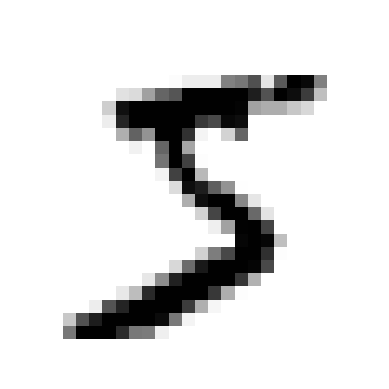

The above digit is a 5.


In [183]:
def plot_image(some_image):
    img = some_image.reshape(28,28)
    plt.imshow(img, cmap='binary')
    plt.axis('off')
    plt.show()
    
plot_image(X[0])
print(f'The above digit is a {y[0]}.')

In [34]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [41]:
y_train_5, y_test_5 = (y_train == '5'), (y_test == '5')

In [44]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [49]:
sgd_clf.predict([X_train[0]])

array([ True])

In [51]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [82]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)

DummyClassifier()

In [83]:
print(any(dummy_clf.predict(X_train)))

False


In [85]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

### Manual Implementation of K-Fold 

In [88]:
skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    X_test_folds = X_train[test_index]
    y_train_folds = y_train_5[train_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct/len(y_pred))

0.95035
0.96035
0.9604


### Confusion Matrix

In [94]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [98]:
cm = confusion_matrix(y_train_5, y_train_pred)
print(cm)

[[53892   687]
 [ 1891  3530]]


In [103]:
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))
print(f1_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311
0.7325171197343846


In [132]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

[  1200.93051237 -26883.79202424 -33072.03475406 ...  13272.12718981
  -7258.47203373 -16877.50840447]


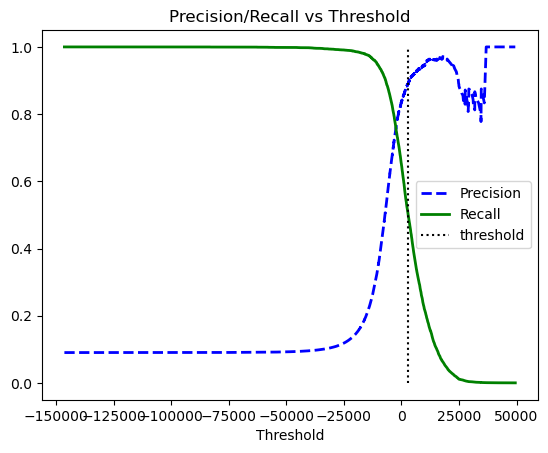

In [56]:
threshold = 3000
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2) 
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2) 
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.xlabel('Threshold')
plt.title('Precision/Recall vs Threshold')
plt.legend(loc='best')

plt.show()

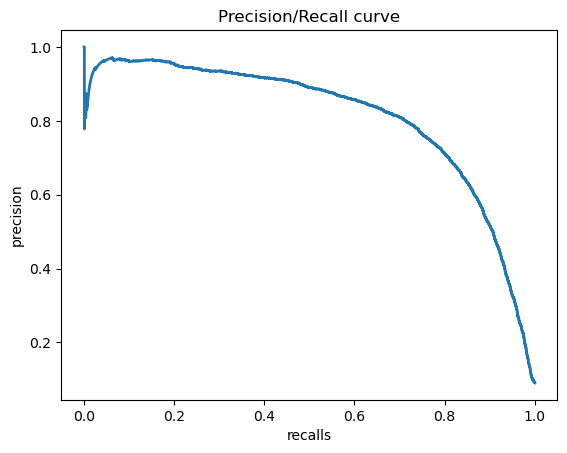

In [58]:
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.xlabel('recalls')
plt.ylabel('precision')
plt.title('Precision/Recall curve')
plt.show()

In [131]:
idx_for_90_precision = (precisions>0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
print(threshold_for_90_precision)

3370.0194991439557


In [135]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


In [137]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [141]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

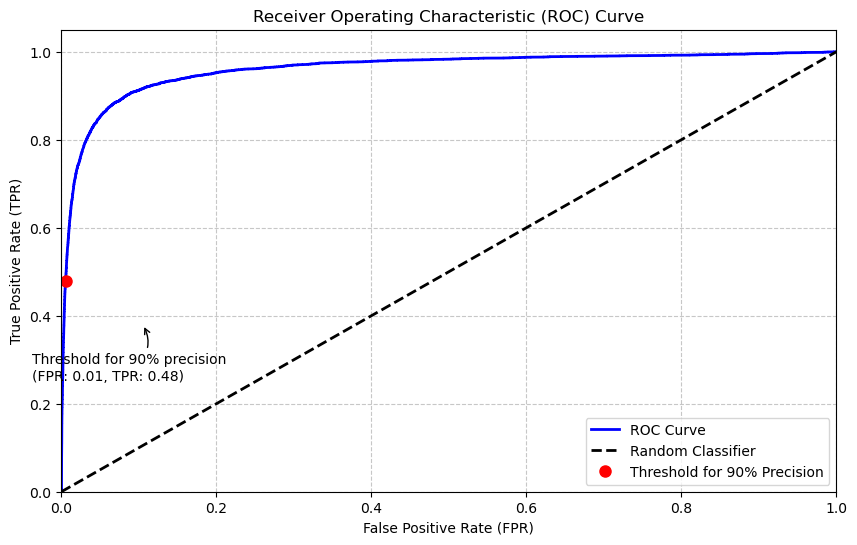

In [154]:
# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, linewidth=2, label="ROC Curve", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier", linewidth=2)

# Plot the specific point for 90% precision
plt.plot([fpr_90], [tpr_90], "ro", markersize=8, label="Threshold for 90% Precision")

# Adding annotations for the specific point
plt.annotate(f"Threshold for 90% precision\n(FPR: {fpr_90:.2f}, TPR: {tpr_90:.2f})",
             xy=(fpr_90 + 0.1, tpr_90 - 0.1), xycoords='data',
             xytext=(-80, -40), textcoords='offset points',
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.5"))

# Set plot limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Add labels and title
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend
plt.legend(loc="lower right")

# Show plot
plt.show()

In [157]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [160]:
forest_clf = RandomForestClassifier(random_state=42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [166]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forst = precision_recall_curve(y_train_5, y_scores_forest)

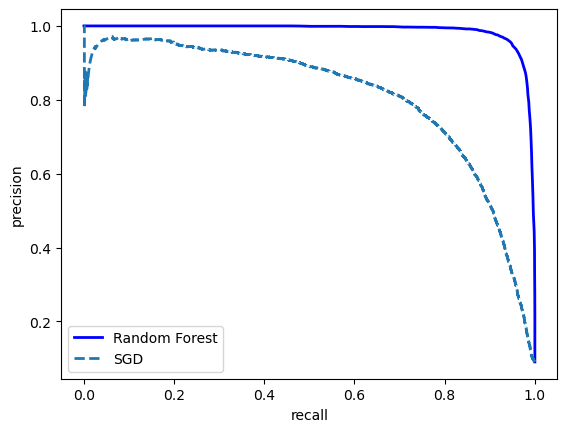

In [168]:
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.xlabel('recall')
plt.ylabel('precision')
plt.legend(loc='lower left')
plt.show()

In [41]:
y_train_pred_forest = y_scores_forest >= 0.5
print(f1_score(y_train_5, y_train_pred_forest))
print(roc_auc_score(y_train_5, y_scores_forest))
print(precision_score(y_train_5, y_train_pred_forest))
print(recall_score(y_train_5, y_train_pred_forest))

0.9274509803921569
0.9983436731328145
0.9897468089558485
0.8725327430363402


### SVM Classifier(45 OvO Classification)

In [44]:
svm_clf = SVC(random_state = 42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

In [46]:
y_train_pred_svm = cross_val_predict(svm_clf, X_train[:2000], y_train[:2000], cv=3)

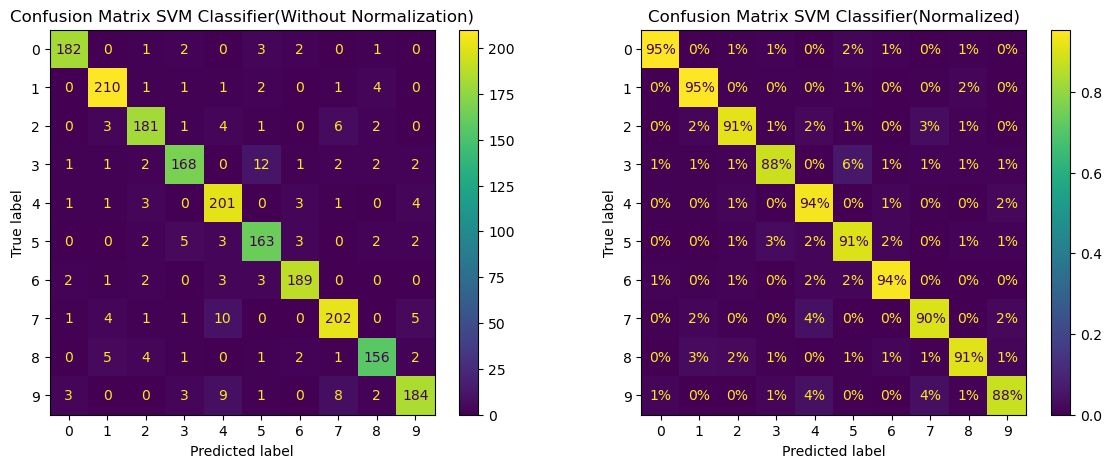

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ConfusionMatrixDisplay.from_predictions(y_train[:2000], y_train_pred_svm, ax=ax[0]) 
ConfusionMatrixDisplay.from_predictions(y_train[:2000], y_train_pred_svm, normalize='true', values_format=".0%", ax=ax[1]) 

ax[0].title.set_text('Confusion Matrix SVM Classifier(Without Normalization)')
ax[1].title.set_text('Confusion Matrix SVM Classifier(Normalized)')

plt.show()

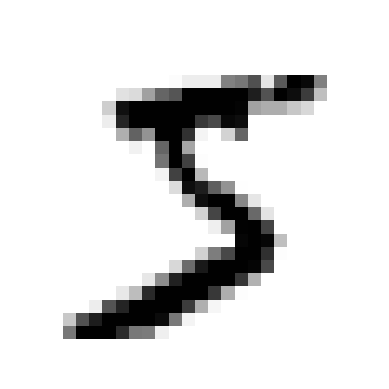

['5'] with decision scores [[ 3.79  0.73  6.06  8.3  -0.29  9.3   1.75  2.77  7.21  4.82]]


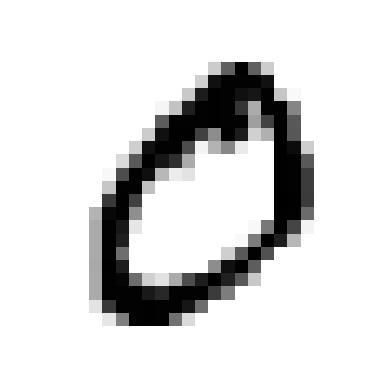

['0'] with decision scores [[ 9.31 -0.29  6.14  7.21  0.71  8.28  3.8   1.77  2.77  5.11]]


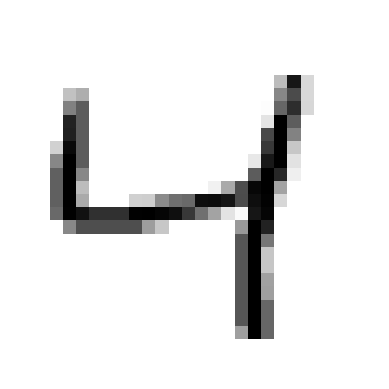

['4'] with decision scores [[ 1.76 -0.29  7.23  1.89  9.3   4.94  3.84  6.1   1.75  8.19]]


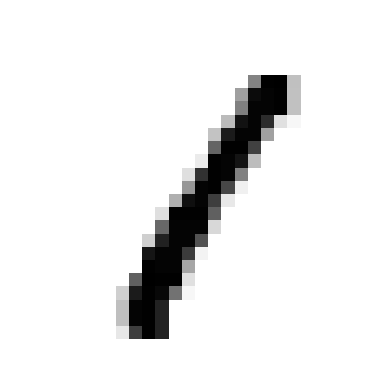

['1'] with decision scores [[-0.29  9.31  7.27  4.83  3.81  2.76  0.73  7.19  7.28  1.73]]


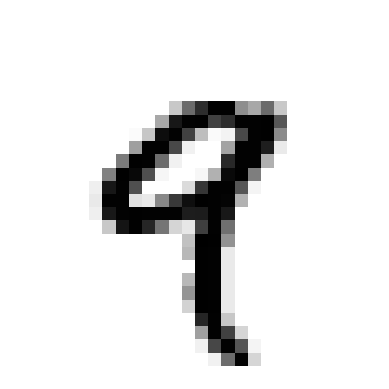

['9'] with decision scores [[-0.29  3.77  2.75  3.75  8.28  2.81  0.72  7.28  6.19  9.31]]


In [192]:
for i in X_train[:5]:
    plot_image(i)
    print(f'{svm_clf.predict([i])} with decision scores {svm_clf.decision_function([i]).round(2)}')
    

In [59]:
cross_val_score(svm_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.977 , 0.9738, 0.9739])

### SGDClassification

In [69]:
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

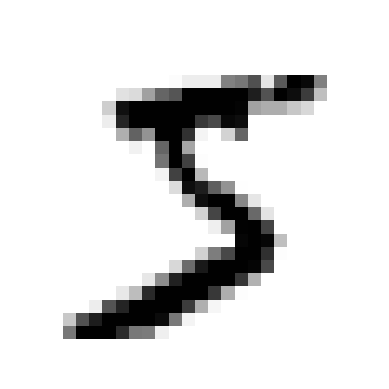

['3'] with decision scores [[-31893.03 -34419.69  -9530.64   1823.73 -22320.15  -1385.8  -26188.91
  -16147.51  -4604.35 -12050.77]]


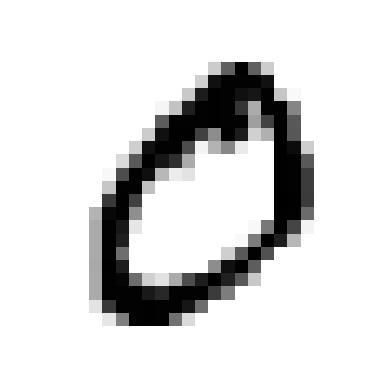

['0'] with decision scores [[ 14390.6  -36919.32  -9811.47  -8054.56 -21825.26 -11313.62 -23649.39
  -15986.78  -3798.53 -10635.47]]


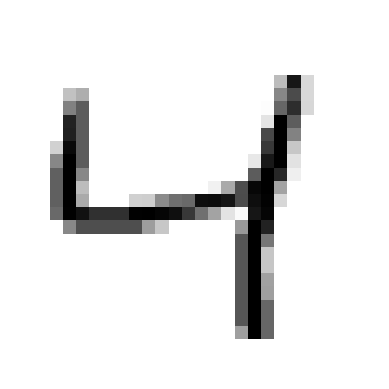

['4'] with decision scores [[-34143.41 -21942.14  -4018.29  -2239.19     43.09 -15058.88 -33653.31
   -8277.81  -7460.52 -14180.15]]


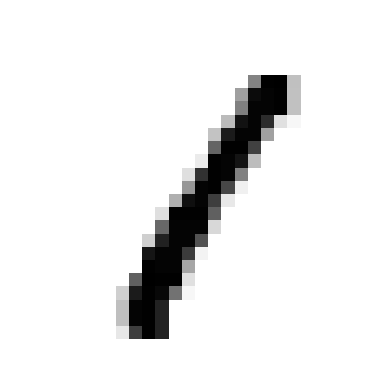

['1'] with decision scores [[-2.368853e+04  6.691140e+03 -4.983560e+03 -2.346580e+03 -8.383020e+03
  -6.935430e+03 -2.490561e+04 -1.144170e+04 -1.483000e+01 -7.440500e+03]]


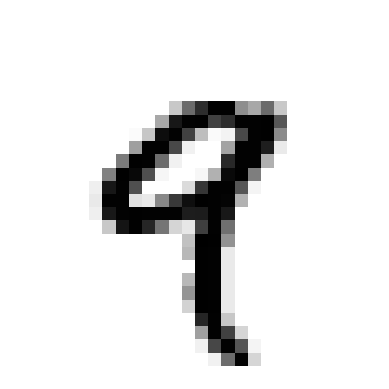

['9'] with decision scores [[-45606.88 -20077.8  -23620.87 -11077.36  -8578.09  -7133.89 -27033.94
   -8312.89  -3257.29   2193.23]]


In [70]:
for i in X_train[:5]:
    plot_image(i)
    print(f'{sgd_clf.predict([i])} with decision scores {sgd_clf.decision_function([i]).round(2)}')

In [71]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")


array([0.87365, 0.85835, 0.8689 ])

In [72]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype('float64'))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [73]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3) 

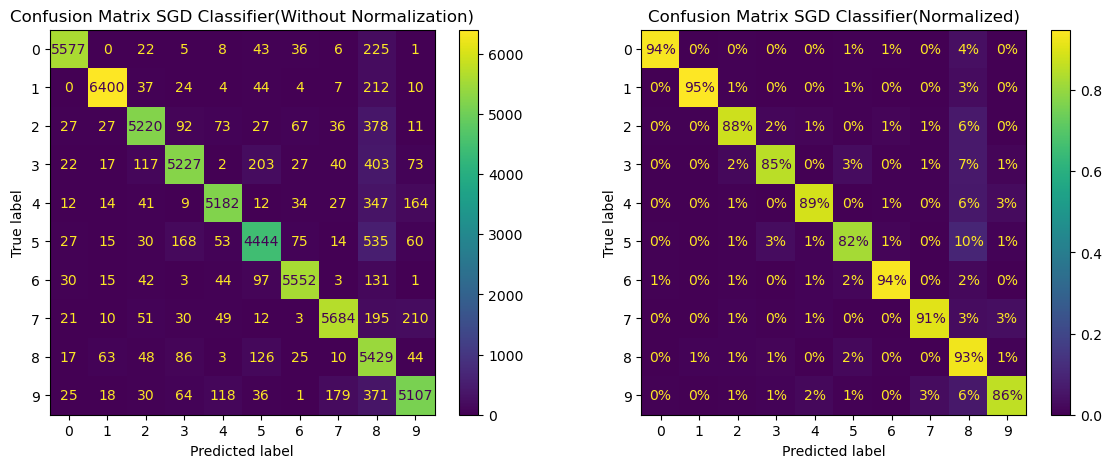

In [74]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ConfusionMatrixDisplay.from_predictions(y_train.astype(int), y_train_pred.astype(int), ax=ax[0]) 
ConfusionMatrixDisplay.from_predictions(y_train.astype(int), y_train_pred.astype(int), normalize='true', values_format=".0%", ax=ax[1]) 

ax[0].title.set_text('Confusion Matrix SGD Classifier(Without Normalization)')
ax[1].title.set_text('Confusion Matrix SGD Classifier(Normalized)')

plt.show()

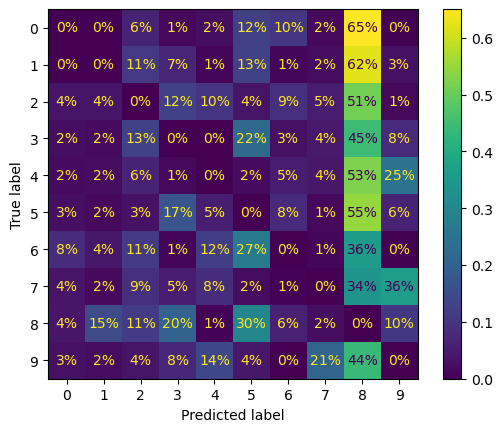

In [75]:
sample_weight = (y_train_pred != y_train) 
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, normalize="true", values_format=".0%")
plt.show()